In [15]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import keras
from keras import layers
from sklearn.metrics import classification_report
import copy
import helper

In [2]:
df = pd.read_csv('./TrafficTwoMonth.csv')
df

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,13,2,2,24,41,normal
1,12:15:00 AM,10,Tuesday,14,1,1,36,52,normal
2,12:30:00 AM,10,Tuesday,10,2,2,32,46,normal
3,12:45:00 AM,10,Tuesday,10,2,2,36,50,normal
4,1:00:00 AM,10,Tuesday,11,2,1,34,48,normal
...,...,...,...,...,...,...,...,...,...
5947,10:45:00 PM,9,Thursday,16,3,1,36,56,normal
5948,11:00:00 PM,9,Thursday,11,0,1,30,42,normal
5949,11:15:00 PM,9,Thursday,15,4,1,25,45,normal
5950,11:30:00 PM,9,Thursday,16,5,0,27,48,normal


Target của dataset này là "Traffic Situation" trong đó có 4 lớp

In [7]:
np.unique(df['Traffic Situation'].values)

array(['heavy', 'high', 'low', 'normal'], dtype=object)

In [25]:
X = df.drop(['Traffic Situation'], axis=1)
y = df[['Traffic Situation']]
X

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total
0,12:00:00 AM,10,Tuesday,13,2,2,24,41
1,12:15:00 AM,10,Tuesday,14,1,1,36,52
2,12:30:00 AM,10,Tuesday,10,2,2,32,46
3,12:45:00 AM,10,Tuesday,10,2,2,36,50
4,1:00:00 AM,10,Tuesday,11,2,1,34,48
...,...,...,...,...,...,...,...,...
5947,10:45:00 PM,9,Thursday,16,3,1,36,56
5948,11:00:00 PM,9,Thursday,11,0,1,30,42
5949,11:15:00 PM,9,Thursday,15,4,1,25,45
5950,11:30:00 PM,9,Thursday,16,5,0,27,48


### Slipting dataset

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Trong dataset này 2 categorial features là "Time" và "Day of the week" và một target cũng có categorical.\
Thông thường với các categorical features dạng thứ thứ bậc ta có thể dùng OrdinalEncoder trong sklearn để thực hiện việc encode. \
OrdinalEncoder giúp ta có thể encode n categories trong 1 categorical feature thành các số nguyên từ 0 đến n - 1. \
Tuy nhiên, OrdinalEncoder encode các categories một cách ngẫu nhiên.

In [29]:
from sklearn.preprocessing import OrdinalEncoder

In [30]:
tmpTrain = copy.copy(X_train)

enc  = OrdinalEncoder()
enc.fit_transform(np.array([tmpTrain['Day of the week']]).reshape(-1, 1))
day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for day in day_of_week :
    print(f'Category: {day} -> Encode {enc.transform(np.array([[day]]).reshape(-1, 1))}')

Category: Monday -> Encode [[1.]]
Category: Tuesday -> Encode [[5.]]
Category: Wednesday -> Encode [[6.]]
Category: Thursday -> Encode [[4.]]
Category: Friday -> Encode [[0.]]
Category: Saturday -> Encode [[2.]]
Category: Sunday -> Encode [[3.]]


Vì mục tiêu là dự đoán chính xác, chúng tôi cài đặt thủ công về việc encode "Day of the week" thủ công. \
Tương tự đối với target "Traffic Situation", ta cũng có thể encode bằng LabelEncoder trong sklearn, tuy nhiên vẫn phải encode thủ công.\
Còn với feature "Time" ta có thể dùng OrdinalEncoder (hoặc LabelEncoder) để thực hiện encode.

In [31]:
X_train, y_train, X_test, y_test = helper.encode(X_train, y_train, X_test, y_test)

In [33]:
X_train.head()

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total
1340,9.0,23,1,14,2,2,28,46
831,47.0,18,3,145,14,35,10,204
5198,44.0,2,4,17,5,1,15,38
1456,48.0,25,3,60,3,6,23,92
1769,2.0,28,6,30,6,26,18,80


In [34]:
y_train.head()

,Traffic Situation
1340,1
831,3
5198,0
1456,1
1769,1


Sau khi đã thực hiện việc encode các categorical features. Bước tiếp theo là scale data về một khoảng nào đó để dễ tính toán.\
Chúng tôi, xin sử dụng StandardScaler trong sklearn đễ thực hiện.

In [36]:
from sklearn.preprocessing import StandardScaler

In [37]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [39]:
print(X_train[:5])

[[-1.40167935  0.77194007 -1.49058669 -1.15068272 -0.88011025 -0.87337728
   0.861664   -1.12630415]
 [-0.02574523  0.21470519 -0.46215099  1.76747472  0.15301737  1.77932996
  -0.77776642  1.68577622]
 [-0.13437161 -1.5684464   0.05206686 -1.08385468 -0.62182835 -0.95376235
  -0.32236908 -1.26868796]
 [ 0.01046356  0.99483402 -0.46215099 -0.12598621 -0.79401628 -0.55183701
   0.40626666 -0.30759721]
 [-1.6551409   1.32917494  1.08050256 -0.79426654 -0.53573438  1.05586435
  -0.04913068 -0.52117293]]


Vì vấn đề là classification, và output layer có activation là softmax, nên target cần phải encode theo onehot (có thể dùng dummy, hoặc to_categorial của keras.utils).\
Ở đây chúng tôi xin sử dụng to_categorical trong keras.utils.

In [40]:
from keras.utils import to_categorical
y_train_tmp = copy.copy(y_train)
y_train_tmp = to_categorical(y_train_tmp)
y_train_onehot = y_train_tmp

In [41]:
y_train_onehot

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

### Train model

In [5]:
model = keras.models.Sequential([
    layers.Dense(16, activation='relu', input_dim=X_train.shape[1]),
    layers.Dense(32, activation='relu'),
    layers.Dense(4, activation='softmax') # target có 4 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Fit model

In [48]:
history = model.fit(X_train, y_train_onehot, epochs=130, batch_size=100, validation_split=0.2, verbose=1)

Epoch 1/130
36/36 [==============================] - 0s 8ms/step - loss: 0.0264 - accuracy: 0.9938 - val_loss: 0.0297 - val_accuracy: 0.9944
Epoch 2/130
36/36 [==============================] - 0s 2ms/step - loss: 0.0267 - accuracy: 0.9922 - val_loss: 0.0330 - val_accuracy: 0.9933
Epoch 3/130
36/36 [==============================] - 0s 2ms/step - loss: 0.0256 - accuracy: 0.9936 - val_loss: 0.0359 - val_accuracy: 0.9910
Epoch 4/130
36/36 [==============================] - 0s 3ms/step - loss: 0.0252 - accuracy: 0.9941 - val_loss: 0.0322 - val_accuracy: 0.9933
Epoch 5/130
36/36 [==============================] - 0s 3ms/step - loss: 0.0259 - accuracy: 0.9930 - val_loss: 0.0304 - val_accuracy: 0.9933
Epoch 6/130
36/36 [==============================] - 0s 3ms/step - loss: 0.0256 - accuracy: 0.9941 - val_loss: 0.0334 - val_accuracy: 0.9899
Epoch 7/130
36/36 [==============================] - 0s 3ms/step - loss: 0.0245 - accuracy: 0.9938 - val_loss: 0.0345 - val_accuracy: 0.9922
Epoch 8/130
3

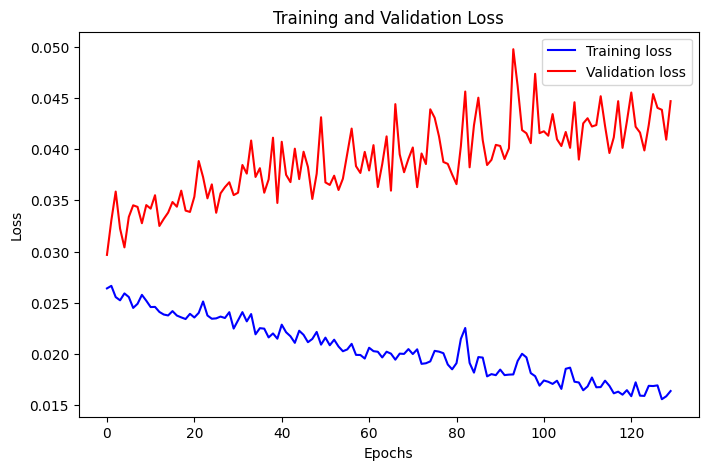

In [51]:
helper.plot_Loss_Val(history)

Tóm tắt các thông tin sau khi fit

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 820 (3.20 KB)
Trainable params: 820 (3.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Predict

In [50]:
y_pred = model.predict(X_test)
y_pred

47/47 [==============================] - 0s 2ms/step


array([[1.00000000e+00, 6.02583033e-14, 0.00000000e+00, 0.00000000e+00],
       [1.03892172e-02, 9.89610434e-01, 4.03940021e-07, 1.09052774e-10],
       [4.16073090e-28, 1.00000000e+00, 1.22025498e-20, 0.00000000e+00],
       ...,
       [7.95717944e-16, 5.32521075e-03, 7.29605244e-06, 9.94667411e-01],
       [4.63831602e-19, 5.01051657e-02, 6.74318017e-07, 9.49894130e-01],
       [2.45126248e-05, 9.99975443e-01, 4.19883739e-10, 0.00000000e+00]],
      dtype=float32)

Với mỗi hàng trong ma trận trên chính là xác xuất của từng class khi model dự đoán 1 input.\
Với mỗi hàng ta sẽ lấy index của element có giá trị lớn nhất, index này cũng chính là class mà model dự đoán cho 1 input.

In [45]:
y_pred = y_pred.argmax(axis=1)
y_pred

array([0, 1, 1, ..., 3, 3, 1], dtype=int64)

Ta thấy rằng model FFNN này có tỉ lệ dự đóan của model này ở mức cao lên đến 99%.

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       179
           1       0.99      0.99      0.99       941
           2       0.96      0.89      0.92       102
           3       0.98      1.00      0.99       266

    accuracy                           0.98      1488
   macro avg       0.97      0.96      0.97      1488
weighted avg       0.98      0.98      0.98      1488

